# Faster RCNN Finetuning
We will finetune a faster RCNN model on a custom dataset (Cat and Dog dataset).

Dataset link: https://univpr-my.sharepoint.com/:u:/g/personal/tomaso_fontanini_unipr_it/EZ0URJL9f4dKvva4QX5-Z14BriQqQc_1h8E0l_GWbbzZvQ?e=Uiebcd
The dataset consists of 2 classes in total.

In [1]:
import torch
BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 416 # resize the image for training and transforms
NUM_EPOCHS = 5 # number of epochs to train for
NUM_WORKERS = 0
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory
TRAIN_DIR = 'res/fasterRCNN/cat_dog/train'
# validation images and XML files directory
VALID_DIR = 'res/fasterRCNN/cat_dog/test'
# classes: 0 index is reserved for background
CLASSES = [
    '__background__', 'cat', 'dog'
]
NUM_CLASSES = len(CLASSES)
# location to save model and plots
OUT_DIR = './res'


In [2]:
# we will need custom transforms since each transforms need to be applied on the bounding box too
import res.transforms as T
    
# define the training tranforms
def get_train_transform():
    return T.Compose([
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float),
        T.RandomHorizontalFlip(p=0.5)
    ])
# define the validation transforms
def get_valid_transform():
    return T.Compose([
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float)
    ])

In [3]:
# Define the DATASET
import cv2 #pip install opencv-python
import numpy as np
import os
import glob as glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# to load bbox files
from xml.etree import ElementTree as et


# Define a function to load images
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
        
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = pil_loader(image_path)
        
        # resize image
        image_resized = image.resize((self.height, self.width))
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width, image_height = image.size
        
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(float(member.find('bndbox').find('xmin').text))
            # xmax = right corner x-coordinates
            xmax = int(float(member.find('bndbox').find('xmax').text))
            # ymin = left corner y-coordinates
            ymin = int(float(member.find('bndbox').find('ymin').text))
            # ymax = right corner y-coordinates
            ymax = int(float(member.find('bndbox').find('ymax').text))
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            image_resized, target = self.transforms(image_resized, target)
            
        return image_resized, target
    def __len__(self):
        return len(self.all_images)

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))    
    
# TRAIN DATASET
train_dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform()
)
print(f"Number of training images: {len(train_dataset)}")

train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )

# TEST DATASET
test_dataset = CustomDataset(
    VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform()
)
print(f"Number of test images: {len(test_dataset)}")

test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn
    )

Number of training images: 1000
Number of test images: 100


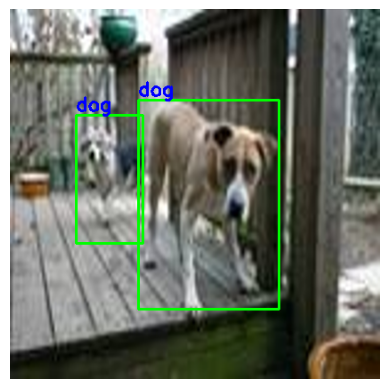

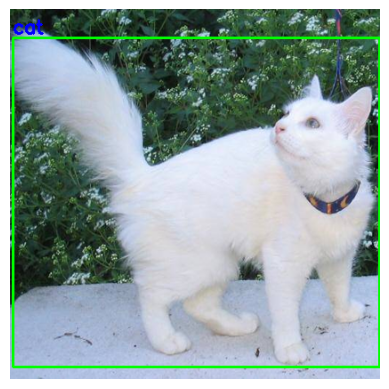

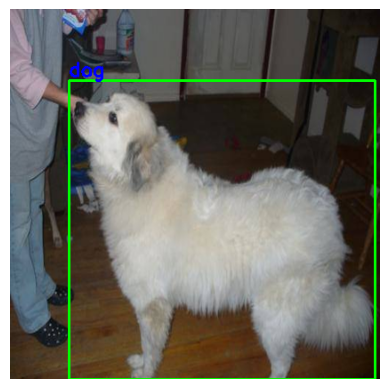

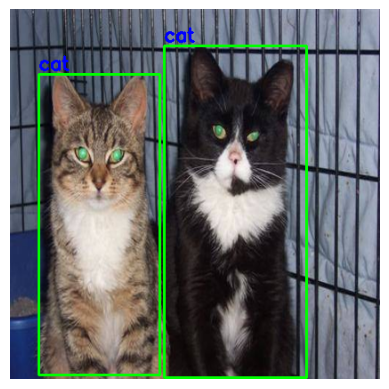

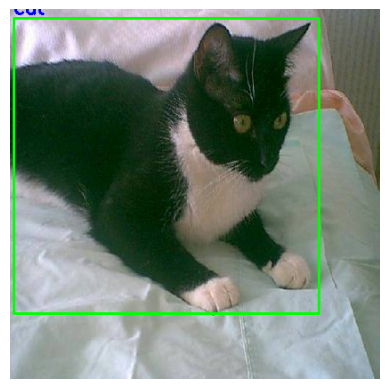

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

to_pil = transforms.ToPILImage()

# function to visualize a single sample
def visualize_sample(image, target):
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]
        
        image = np.array(to_pil(image))
        
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
    plt.imshow(image)
    plt.axis('off')


NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    plt.figure()
    r = random.randint(0, len(test_dataset)-1)
    image, target = test_dataset[r]
    visualize_sample(image, target)

In [4]:
# Create the Faster RCNN model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='COCO_V1', trainable_backbone_layers=3)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [6]:
# let's check what paramenters will be learned
for n,p in model.named_parameters():
    if p.requires_grad:
        print(n)
print(model)

backbone.body.7.block.0.0.weight
backbone.body.7.block.1.0.weight
backbone.body.7.block.2.0.weight
backbone.body.8.block.0.0.weight
backbone.body.8.block.1.0.weight
backbone.body.8.block.2.0.weight
backbone.body.9.block.0.0.weight
backbone.body.9.block.1.0.weight
backbone.body.9.block.2.0.weight
backbone.body.10.block.0.0.weight
backbone.body.10.block.1.0.weight
backbone.body.10.block.2.0.weight
backbone.body.11.block.0.0.weight
backbone.body.11.block.1.0.weight
backbone.body.11.block.2.fc1.weight
backbone.body.11.block.2.fc1.bias
backbone.body.11.block.2.fc2.weight
backbone.body.11.block.2.fc2.bias
backbone.body.11.block.3.0.weight
backbone.body.12.block.0.0.weight
backbone.body.12.block.1.0.weight
backbone.body.12.block.2.fc1.weight
backbone.body.12.block.2.fc1.bias
backbone.body.12.block.2.fc2.weight
backbone.body.12.block.2.fc2.bias
backbone.body.12.block.3.0.weight
backbone.body.13.block.0.0.weight
backbone.body.13.block.1.0.weight
backbone.body.13.block.2.fc1.weight
backbone.body

In [7]:
# define train and test functions
from tqdm import tqdm #pip install tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    train_loss_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images =  list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets) # when given images and targets as input it will return the loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

def validate(valid_data_loader, model):
    print('Validating')
    val_itr = 0
    val_loss_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [8]:
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'res/faster_rcnn_cat_dog.pth')

In [ ]:
# TRAIN!!!
import time
model.train()
for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(test_loader, model)
        print(f"Epoch #{epoch+1} train loss: {sum(train_loss)/len(train_loader):.3f}")   
        print(f"Epoch #{epoch+1} validation loss: {sum(val_loss)/len(test_loader):.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        # save the current epoch model
        save_model(epoch, model, optimizer)
        


EPOCH 1 of 5
Training


Loss: 0.9785: 100%|██████████| 250/250 [02:33<00:00,  1.63it/s]


Validating


Loss: 0.7112: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


Epoch #1 train loss: 0.902
Epoch #1 validation loss: 0.623
Took 2.800 minutes for epoch 0

EPOCH 2 of 5
Training


Loss: 0.5147: 100%|██████████| 250/250 [01:55<00:00,  2.17it/s]


Validating


Loss: 0.5640: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Epoch #2 train loss: 0.674
Epoch #2 validation loss: 0.638
Took 2.087 minutes for epoch 1

EPOCH 3 of 5
Training


Loss: 0.5966: 100%|██████████| 250/250 [02:10<00:00,  1.91it/s]


Validating


Loss: 0.7566: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Epoch #3 train loss: 0.569
Epoch #3 validation loss: 0.604
Took 2.352 minutes for epoch 2

EPOCH 4 of 5
Training


Loss: 0.6331: 100%|██████████| 250/250 [02:14<00:00,  1.86it/s]


Validating


Loss: 0.6232: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Epoch #4 train loss: 0.536
Epoch #4 validation loss: 0.678
Took 2.417 minutes for epoch 3

EPOCH 5 of 5
Training


Loss: 0.2611: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


Validating


Loss: 0.6454: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]

Epoch #5 train loss: 0.497
Epoch #5 validation loss: 0.635
Took 2.042 minutes for epoch 4


In [5]:
# load the model and trained weights
checkpoint = torch.load('res/faster_rcnn_cat_dog.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

C:\Users\Tomaso Fontanini\AppData\Local\Temp\ipykernel_32476\110054086.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('res/faster_rcnn_cat_dog.p

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

TEST PREDICTIONS COMPLETE
Average FPS: 4.288


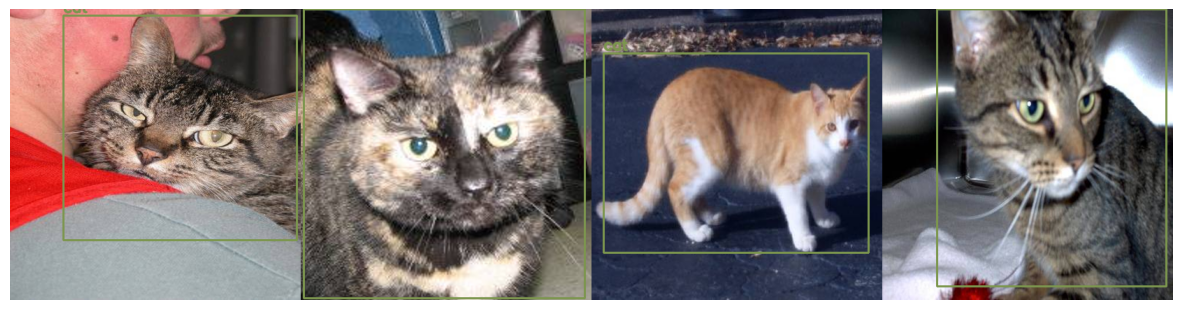

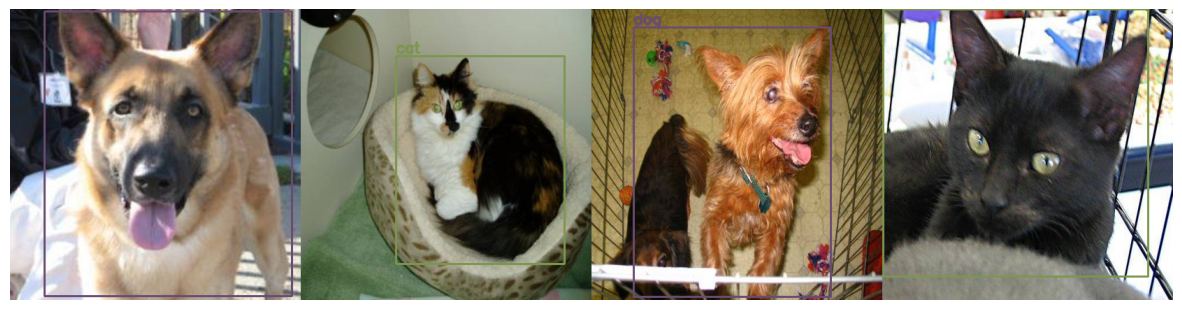

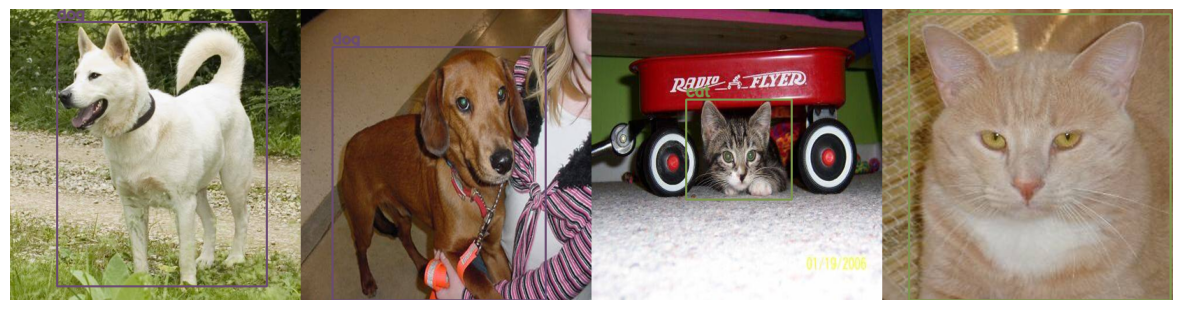

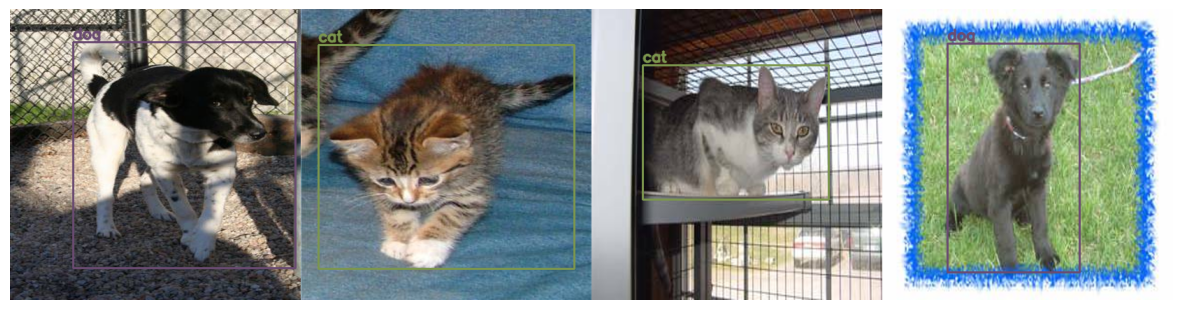

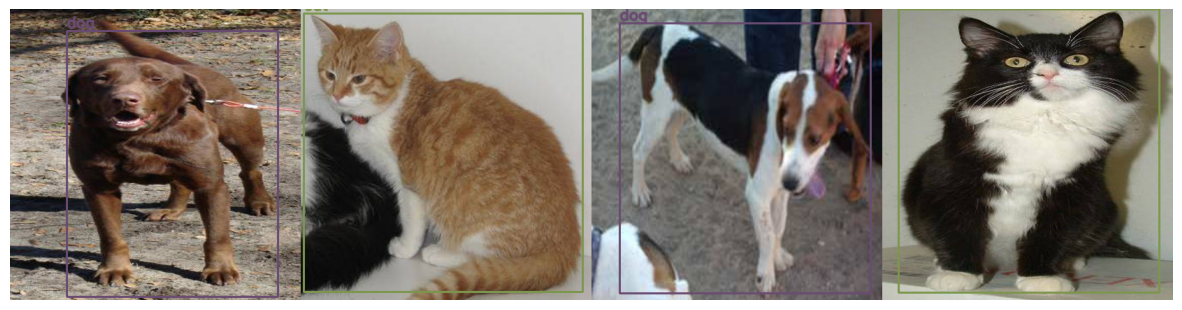

In [11]:
# Evaluate the model and print the results
import time
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8

# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0 

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

with torch.no_grad():
    for i, data in enumerate(test_loader):
        
        if i > 4:
            break
            
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        start_time = time.time()
        
        # generate outputs from model
        outputs = model(images) # when given only images as input it will return the generated output
        
        end_time = time.time()
        # get the current fps
        fps = 1 / (end_time - start_time)
        # add `fps` to `total_fps`
        total_fps += fps
        # increment frame count
        frame_count += 1
        # load all detection to CPU for further operations
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        
        images = [np.array(to_pil(im)) for im in images]
        
        targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
        
        plt.figure(figsize=(15,15))
        res_list = []
        for (out, im, trg) in zip(outputs, images, targets):
            # carry further only if there are detected boxes
            if len(out['boxes']) != 0:
                boxes = out['boxes'].data.numpy()
                scores = out['scores'].data.numpy()
                # filter out boxes according to `detection_threshold`
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                # get all the predicited class names
                pred_classes = [CLASSES[i] for i in out['labels'].cpu().numpy()]

                # draw the bounding boxes and write the class name on top of it
                for j, box in enumerate(draw_boxes):
                    class_name = pred_classes[j]
                    color = COLORS[CLASSES.index(class_name)]
                    cv2.rectangle(im,
                                (int(box[0]), int(box[1])),
                                (int(box[2]), int(box[3])),
                                color, 2)
                    cv2.putText(im, class_name, 
                                (int(box[0]), int(box[1]-5)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                                2, lineType=cv2.LINE_AA)
                 
                res_list.append(im)
        
        res_list = np.concatenate(res_list, axis=1)
        plt.axis("off")
        plt.imshow(res_list)

print('TEST PREDICTIONS COMPLETE')
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Model Link: https://univpr-my.sharepoint.com/:u:/g/personal/tomaso_fontanini_unipr_it/EaZxOJeIZ6dPkffF_i7EtTsBLcGoUvK2KzETcfeTeNoRLQ?e=iutcpU

### Object Detection Metrics: mIOU and mAP

**Mean Intersection over Union (mIOU)** is a standard metric for evaluating the accuracy of an object detector. It measures the overlap between the predicted bounding box and the ground-truth bounding box.

The **IoU** for a single prediction is calculated as the area of the intersection divided by the area of the union of the predicted and ground-truth boxes. A higher IoU value indicates a more accurate prediction.

**Mean Average Precision (mAP)** 
$$mAP=\frac{1}{n}\sum\limits_{i=1}^{n}AP_i$$
The average precision $AP_i$ is defined as the area under the precision-recall curve. For object detection the recall and precision are defined based on the intersection of union (IoU) between the predicted bounding boxes and the ground truth bounding boxes e.g. if two boxes have an IoU > t (with t being some threshold) they are considered a match and therefore considered a true positive. The precision is then defined as the number of true positives divided by the number of all detected boxes and the recall is defined as the number of true positives divided by the number of all ground boxes

In [ ]:
#!pip install torchmetrics
#!pip install pycocotools
#!pip install faster-coco-eval

In [ ]:
#mIoU calculation
from torchmetrics.detection.iou import IntersectionOverUnion

mIoU_metric = IntersectionOverUnion()
# move the model to the right device
model.to(DEVICE)
model.eval()

with torch.no_grad():
    # iterate over the test loader
    for images, targets in tqdm(test_loader, desc="Calculating Metrics"):
        images = list(img.to(DEVICE) for img in images)
        
        # get model predictions
        outputs = model(images)

        # move predictions to cpu
        preds = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        # update the metric with the predictions and ground truth
        mIoU_metric.update(preds, targets)

# compute the final metrics
results = mIoU_metric.compute()
print(f"Mean IoU: {results['iou']:.4f}")


Calculating Metrics:   4%|▍         | 1/25 [00:00<00:12,  1.97it/s]

[{'boxes': tensor([[  8.1254,  53.3178, 185.2206, 369.7872],
        [  6.5507,  65.5433, 187.6586, 361.5454]]), 'labels': tensor([2, 1]), 'scores': tensor([0.9644, 0.1127])}, {'boxes': tensor([[  4.3370,  20.0386, 403.2244, 413.5350]]), 'labels': tensor([1]), 'scores': tensor([0.9986])}, {'boxes': tensor([[ 25.6734,   5.6116, 392.6324, 388.1460]]), 'labels': tensor([2]), 'scores': tensor([0.9986])}, {'boxes': tensor([[167.9187,  15.7549, 416.0000, 290.6003],
        [  1.5122,  27.0999, 251.6454, 341.8900]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9802, 0.7990])}] ({'boxes': tensor([[  7.8000,  78.3264, 198.9000, 342.8954]]), 'labels': tensor([2]), 'area': tensor([50559.1406]), 'iscrowd': tensor([0]), 'image_id': tensor([85])}, {'boxes': tensor([[ 19.2174,  35.0140, 396.7826, 406.8297]]), 'labels': tensor([1]), 'area': tensor([140384.6562]), 'iscrowd': tensor([0]), 'image_id': tensor([49])}, {'boxes': tensor([[ 29.9000,  17.4241, 391.3000, 389.8639]]), 'labels': tensor([2]), 'a

Calculating Metrics:   8%|▊         | 2/25 [00:00<00:07,  2.98it/s]

[{'boxes': tensor([[ 54.8221,  36.0332, 396.4119, 398.6203],
        [ 47.9039,  89.3134, 365.0848, 398.3405]]), 'labels': tensor([2, 1]), 'scores': tensor([0.9906, 0.0601])}, {'boxes': tensor([[ 53.5857,  74.1709, 403.7890, 311.2747]]), 'labels': tensor([1]), 'scores': tensor([0.9970])}, {'boxes': tensor([[  0.0000,   0.0000, 401.0768, 405.2330]]), 'labels': tensor([1]), 'scores': tensor([0.9970])}, {'boxes': tensor([[ 87.9018, 133.6244, 373.6752, 413.9359],
        [113.7630, 138.7892, 392.2683, 409.0169]]), 'labels': tensor([2, 1]), 'scores': tensor([0.9888, 0.0507])}] ({'boxes': tensor([[ 61.6914,  77.8431, 348.4729, 385.0302]]), 'labels': tensor([2]), 'area': tensor([88095.6016]), 'iscrowd': tensor([0]), 'image_id': tensor([69])}, {'boxes': tensor([[ 58.2400,  74.7239, 402.6880, 310.0482]]), 'labels': tensor([1]), 'area': tensor([81057.0156]), 'iscrowd': tensor([0]), 'image_id': tensor([25])}, {'boxes': tensor([[  2.8428,   5.8357, 405.5763, 413.4990]]), 'labels': tensor([1]), 'ar

Calculating Metrics:  12%|█▏        | 3/25 [00:00<00:06,  3.50it/s]

[{'boxes': tensor([[169.2155,  30.5239, 325.9682, 414.1552],
        [ 22.3199,  45.0192, 182.7890, 416.0000],
        [ 65.3677,  40.2435, 260.7767, 410.0355]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9968, 0.9944, 0.1173])}, {'boxes': tensor([[  0.0000,  13.1346, 416.0000, 395.4841]]), 'labels': tensor([1]), 'scores': tensor([0.9897])}, {'boxes': tensor([[ 38.2465,  57.5993, 396.1952, 394.3174],
        [ 42.1340,  50.6680, 386.3936, 396.9787]]), 'labels': tensor([1, 2]), 'scores': tensor([0.9328, 0.2430])}, {'boxes': tensor([[ 61.0509,   1.6968, 351.1688, 397.1127]]), 'labels': tensor([2]), 'scores': tensor([0.9970])}] ({'boxes': tensor([[ 32.4480,  73.4118, 168.8960, 411.5508],
        [173.0560,  41.1551, 333.6320, 414.8877]]), 'labels': tensor([1, 1]), 'area': tensor([46138.3945, 60012.4844]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([8])}, {'boxes': tensor([[  2.2246,   4.1600, 414.8877, 392.7040]]), 'labels': tensor([1]), 'area': tensor([160337.7656]), 'iscrowd':

Calculating Metrics:  20%|██        | 5/25 [00:01<00:04,  4.16it/s]

[{'boxes': tensor([[142.4265,  80.1065, 374.3210, 328.5634],
        [  6.1145, 239.3257, 132.2931, 407.6263],
        [ 97.7100,  92.9402, 270.9207, 303.2111]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9965, 0.6850, 0.0572])}, {'boxes': tensor([[ 21.4154,  38.4497, 373.1476, 408.5918]]), 'labels': tensor([2]), 'scores': tensor([0.9985])}, {'boxes': tensor([[ 61.0601,  28.6356, 391.6240, 391.7995],
        [ 47.3842,  35.2034, 267.2989, 333.6934]]), 'labels': tensor([2, 2]), 'scores': tensor([0.9953, 0.1430])}, {'boxes': tensor([[ 90.4909,  39.7299, 277.7492, 385.2323]]), 'labels': tensor([2]), 'scores': tensor([0.9977])}] ({'boxes': tensor([[  0.8320, 235.8075, 134.7840, 416.0000],
        [103.1680, 101.2193, 391.8720, 328.1284]]), 'labels': tensor([1, 1]), 'area': tensor([24137.1484, 65509.5664]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([39])}, {'boxes': tensor([[ 18.0267,  44.9730, 373.0133, 406.1622]]), 'labels': tensor([2]), 'area': tensor([128217.3516]), 'iscrowd'

Calculating Metrics:  24%|██▍       | 6/25 [00:01<00:04,  4.33it/s]

[{'boxes': tensor([[ 12.3211,   5.1639, 397.4004, 412.0924]]), 'labels': tensor([1]), 'scores': tensor([0.9840])}, {'boxes': tensor([[ 48.8442,  19.5237, 388.4632, 406.9503]]), 'labels': tensor([2]), 'scores': tensor([0.9979])}, {'boxes': tensor([[ 43.7614,   3.5840, 398.3838, 407.7194]]), 'labels': tensor([2]), 'scores': tensor([0.9953])}, {'boxes': tensor([[ 19.8243,  11.0002, 360.5821, 401.3465]]), 'labels': tensor([2]), 'scores': tensor([0.9983])}] ({'boxes': tensor([[  5.0020,   1.1093, 368.4810, 349.4400]]), 'labels': tensor([1]), 'area': tensor([126610.8594]), 'iscrowd': tensor([0]), 'image_id': tensor([0])}, {'boxes': tensor([[ 60.6897,  19.6992, 396.1379, 411.3649]]), 'labels': tensor([2]), 'area': tensor([131383.5938]), 'iscrowd': tensor([0]), 'image_id': tensor([93])}, {'boxes': tensor([[ 47.9162,   6.9141, 394.2199, 410.2382]]), 'labels': tensor([2]), 'area': tensor([139672.6250]), 'iscrowd': tensor([0]), 'image_id': tensor([96])}, {'boxes': tensor([[ 23.2960,  15.5722, 367

Calculating Metrics:  28%|██▊       | 7/25 [00:01<00:04,  4.40it/s]

[{'boxes': tensor([[  0.0000,   1.0679, 416.0000, 416.0000]]), 'labels': tensor([1]), 'scores': tensor([0.9961])}, {'boxes': tensor([[  5.1757,  13.3951, 405.8442, 377.5525]]), 'labels': tensor([1]), 'scores': tensor([0.9950])}, {'boxes': tensor([[  1.2396,  64.0497, 332.6661, 319.2105]]), 'labels': tensor([1]), 'scores': tensor([0.9902])}, {'boxes': tensor([[131.6227, 125.6269, 294.0178, 270.6741],
        [ 29.2699,  46.5648, 373.6819, 274.5137]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9596, 0.2070])}] ({'boxes': tensor([[ 22.2460,   4.9920, 414.8877, 396.8640]]), 'labels': tensor([1]), 'area': tensor([153865.2969]), 'iscrowd': tensor([0]), 'image_id': tensor([32])}, {'boxes': tensor([[  9.9840,   2.6000, 413.5040, 390.0000]]), 'labels': tensor([1]), 'area': tensor([156323.6406]), 'iscrowd': tensor([0]), 'image_id': tensor([37])}, {'boxes': tensor([[  0.0000,  49.9200, 325.9037, 332.8000]]), 'labels': tensor([1]), 'area': tensor([92191.6562]), 'iscrowd': tensor([0]), 'image_i

Calculating Metrics:  40%|████      | 10/25 [00:02<00:03,  4.84it/s]

[{'boxes': tensor([[ 25.1465,  16.6357, 402.4437, 369.8483],
        [ 27.1639,  27.6307, 416.0000, 375.6909]]), 'labels': tensor([2, 1]), 'scores': tensor([0.4429, 0.3218])}, {'boxes': tensor([[  1.1172,  27.5301, 304.6288, 406.7909]]), 'labels': tensor([2]), 'scores': tensor([0.9976])}, {'boxes': tensor([[  2.1740,   0.0000, 392.4251, 384.1836]]), 'labels': tensor([1]), 'scores': tensor([0.9955])}, {'boxes': tensor([[ 79.4862,  25.0951, 365.6043, 398.5562]]), 'labels': tensor([2]), 'scores': tensor([0.9937])}] ({'boxes': tensor([[ 23.1111,  17.7778, 399.4921, 401.7778]]), 'labels': tensor([2]), 'area': tensor([144530.2812]), 'iscrowd': tensor([0]), 'image_id': tensor([54])}, {'boxes': tensor([[  1.0024,  26.0000, 282.6795, 413.4000]]), 'labels': tensor([2]), 'area': tensor([109121.7031]), 'iscrowd': tensor([0]), 'image_id': tensor([57])}, {'boxes': tensor([[  0.0000,  26.2935, 384.3840, 395.3409]]), 'labels': tensor([1]), 'area': tensor([141855.9219]), 'iscrowd': tensor([0]), 'image_

Calculating Metrics:  48%|████▊     | 12/25 [00:02<00:02,  4.94it/s]

[{'boxes': tensor([[ 86.6726,  19.9243, 302.1723, 386.1110]]), 'labels': tensor([1]), 'scores': tensor([0.9963])}, {'boxes': tensor([[ 35.4278,   0.0000, 412.7939, 414.5369]]), 'labels': tensor([1]), 'scores': tensor([0.9963])}, {'boxes': tensor([[ 40.7703,   3.5484, 388.9069, 416.0000]]), 'labels': tensor([2]), 'scores': tensor([0.9983])}, {'boxes': tensor([[  0.0000,   7.8620, 367.3361, 415.7277]]), 'labels': tensor([1]), 'scores': tensor([0.9940])}] ({'boxes': tensor([[ 92.3520,  48.2474, 294.5280, 380.6186]]), 'labels': tensor([1]), 'area': tensor([67197.4766]), 'iscrowd': tensor([0]), 'image_id': tensor([33])}, {'boxes': tensor([[ 41.2414,   0.0000, 399.8621, 414.4593]]), 'labels': tensor([1]), 'area': tensor([148633.6562]), 'iscrowd': tensor([0]), 'image_id': tensor([6])}, {'boxes': tensor([[ 41.9104,   1.5127, 397.3731, 409.9491]]), 'labels': tensor([2]), 'area': tensor([145183.8906]), 'iscrowd': tensor([0]), 'image_id': tensor([66])}, {'boxes': tensor([[  1.6673,   1.3821, 355.

Calculating Metrics:  52%|█████▏    | 13/25 [00:03<00:02,  4.87it/s]

[{'boxes': tensor([[ 70.7722,  82.8581, 349.8187, 290.2819]]), 'labels': tensor([1]), 'scores': tensor([0.9895])}, {'boxes': tensor([[ 25.9869,   0.0000, 393.8513, 416.0000]]), 'labels': tensor([1]), 'scores': tensor([0.9917])}, {'boxes': tensor([[  5.9797,   2.2217, 370.3608, 415.1394]]), 'labels': tensor([2]), 'scores': tensor([0.9992])}, {'boxes': tensor([[ 19.5693,   6.7590, 412.5427, 387.4598]]), 'labels': tensor([1]), 'scores': tensor([0.9965])}] ({'boxes': tensor([[ 73.4933,  76.1429, 345.2800, 297.1429]]), 'labels': tensor([1]), 'area': tensor([60064.8555]), 'iscrowd': tensor([0]), 'image_id': tensor([2])}, {'boxes': tensor([[ 32.7826,   3.6174, 380.9565, 414.1913]]), 'labels': tensor([1]), 'area': tensor([142951.1094]), 'iscrowd': tensor([0]), 'image_id': tensor([41])}, {'boxes': tensor([[  6.4198,   5.3677, 371.0617, 410.6323]]), 'labels': tensor([2]), 'area': tensor([147776.4688]), 'iscrowd': tensor([0]), 'image_id': tensor([76])}, {'boxes': tensor([[ 65.7280,  15.6301, 411.

Calculating Metrics:  56%|█████▌    | 14/25 [00:03<00:02,  4.80it/s]

[{'boxes': tensor([[104.1849,  13.2303, 306.9560, 411.9641]]), 'labels': tensor([2]), 'scores': tensor([0.9937])}, {'boxes': tensor([[  0.0000,   4.3108, 406.7580, 407.6066]]), 'labels': tensor([1]), 'scores': tensor([0.9968])}, {'boxes': tensor([[241.3183, 188.3952, 369.7500, 413.7129],
        [ 47.8152,  57.8941, 350.6093, 411.2149],
        [ 53.2314,  42.0919, 319.0777, 416.0000],
        [237.5078, 176.6868, 385.6768, 416.0000],
        [275.6333,  75.0551, 412.5246, 368.2347]]), 'labels': tensor([2, 2, 1, 1, 1]), 'scores': tensor([0.9531, 0.2048, 0.1725, 0.1550, 0.0535])}, {'boxes': tensor([[ 24.2357,  16.2405, 404.3041, 415.2371]]), 'labels': tensor([2]), 'scores': tensor([0.9974])}] ({'boxes': tensor([[ 86.7014,   5.5467, 310.9579, 409.3440]]), 'labels': tensor([2]), 'area': tensor([90554.1797]), 'iscrowd': tensor([0]), 'image_id': tensor([82])}, {'boxes': tensor([[  0.0000,   6.2090, 403.6190, 411.0328]]), 'labels': tensor([1]), 'area': tensor([163394.6250]), 'iscrowd': tenso

Calculating Metrics:  60%|██████    | 15/25 [00:03<00:02,  4.64it/s]

[{'boxes': tensor([[104.7311, 124.4871, 217.0330, 269.8021]]), 'labels': tensor([1]), 'scores': tensor([0.9952])}, {'boxes': tensor([[ 86.1866,  48.2819, 275.0403, 414.4019]]), 'labels': tensor([2]), 'scores': tensor([0.9972])}, {'boxes': tensor([[ 18.6371,  28.3956, 397.5480, 381.5724]]), 'labels': tensor([2]), 'scores': tensor([0.9942])}, {'boxes': tensor([[  9.7138,   1.5157, 395.4260, 403.8080]]), 'labels': tensor([2]), 'scores': tensor([0.9982])}] ({'boxes': tensor([[103.1680, 124.5775, 219.6480, 275.8503]]), 'labels': tensor([1]), 'area': tensor([17620.2480]), 'iscrowd': tensor([0]), 'image_id': tensor([48])}, {'boxes': tensor([[ 86.5280,  43.3797, 259.5840, 412.6631]]), 'labels': tensor([2]), 'area': tensor([63906.7227]), 'iscrowd': tensor([0]), 'image_id': tensor([52])}, {'boxes': tensor([[ 12.8992,  34.3200, 407.9380, 376.4800]]), 'labels': tensor([2]), 'area': tensor([135166.4688]), 'iscrowd': tensor([0]), 'image_id': tensor([84])}, {'boxes': tensor([[ 11.5556,  12.7465, 408.

Calculating Metrics:  64%|██████▍   | 16/25 [00:03<00:01,  4.60it/s]

[{'boxes': tensor([[ 66.3406,  63.9925, 318.1330, 411.7063]]), 'labels': tensor([1]), 'scores': tensor([0.9956])}, {'boxes': tensor([[ 24.9791,  10.8925, 354.7059, 412.9645]]), 'labels': tensor([2]), 'scores': tensor([0.9982])}, {'boxes': tensor([[  3.8139,   4.1631, 358.5561, 401.4055]]), 'labels': tensor([1]), 'scores': tensor([0.9970])}, {'boxes': tensor([[ 18.5939,  13.6956, 379.3568, 342.1291]]), 'labels': tensor([2]), 'scores': tensor([0.9976])}] ({'boxes': tensor([[100.9493,  67.5271, 319.4880, 416.0000]]), 'labels': tensor([1]), 'area': tensor([76154.8125]), 'iscrowd': tensor([0]), 'image_id': tensor([36])}, {'boxes': tensor([[ 41.6000,  19.8957, 339.7333, 401.5304]]), 'labels': tensor([2]), 'area': tensor([113778.0469]), 'iscrowd': tensor([0]), 'image_id': tensor([89])}, {'boxes': tensor([[ 15.5224,  11.6713, 332.1791, 401.8277]]), 'labels': tensor([1]), 'area': tensor([123545.6094]), 'iscrowd': tensor([0]), 'image_id': tensor([26])}, {'boxes': tensor([[ 38.2720,  17.3695, 379

Calculating Metrics:  72%|███████▏  | 18/25 [00:04<00:01,  4.70it/s]

[{'boxes': tensor([[ 72.0292,  25.5162, 398.8626, 350.9510]]), 'labels': tensor([2]), 'scores': tensor([0.9904])}, {'boxes': tensor([[ 19.5222,   0.0000, 401.6420, 405.6094]]), 'labels': tensor([1]), 'scores': tensor([0.9968])}, {'boxes': tensor([[  6.6245,  10.3033, 230.9923, 414.1972],
        [246.3716, 109.5397, 413.2145, 405.5187],
        [131.3451,  34.7178, 393.8314, 406.3445]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9772, 0.9722, 0.1811])}, {'boxes': tensor([[167.4827, 131.7990, 377.2333, 404.2825],
        [ 68.9783,  73.1985, 192.4351, 402.3289],
        [ 59.9306,  63.1695, 324.8850, 416.0000]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9956, 0.9885, 0.0602])}] ({'boxes': tensor([[ 87.5351,  23.7357, 406.8297, 342.2943]]), 'labels': tensor([2]), 'area': tensor([101714.0156]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}, {'boxes': tensor([[ 29.8208,   6.6693, 395.1255, 404.3286]]), 'labels': tensor([1]), 'area': tensor([145266.7969]), 'iscrowd': tens

Calculating Metrics:  76%|███████▌  | 19/25 [00:04<00:01,  4.87it/s]

[{'boxes': tensor([[100.1716,   7.2439, 366.5994, 413.1306]]), 'labels': tensor([1]), 'scores': tensor([0.9964])}, {'boxes': tensor([[ 21.5522,  24.2753, 399.8202, 416.0000]]), 'labels': tensor([2]), 'scores': tensor([0.9986])}, {'boxes': tensor([[175.5500, 107.5070, 305.0314, 372.2799]]), 'labels': tensor([2]), 'scores': tensor([0.9978])}, {'boxes': tensor([[  5.6060,  74.2916, 413.4322, 347.6115]]), 'labels': tensor([1]), 'scores': tensor([0.9985])}] ({'boxes': tensor([[100.0401,   0.0000, 363.4789, 404.9067]]), 'labels': tensor([1]), 'area': tensor([106668.1562]), 'iscrowd': tensor([0]), 'image_id': tensor([42])}, {'boxes': tensor([[ 26.1965,  31.6160, 411.8086, 412.6720]]), 'labels': tensor([2]), 'area': tensor([146939.7969]), 'iscrowd': tensor([0]), 'image_id': tensor([79])}, {'boxes': tensor([[172.5691, 119.8080, 308.4569, 370.5173]]), 'labels': tensor([2]), 'area': tensor([34068.3320]), 'iscrowd': tensor([0]), 'image_id': tensor([73])}, {'boxes': tensor([[ 15.6391,  87.9758, 399

Calculating Metrics:  80%|████████  | 20/25 [00:04<00:01,  4.86it/s]

[{'boxes': tensor([[ 31.2766,  14.9905, 405.0932, 400.8921],
        [185.4377,  45.2623, 388.0522, 411.2658]]), 'labels': tensor([2, 2]), 'scores': tensor([0.9955, 0.4557])}, {'boxes': tensor([[141.7563,  93.8049, 302.1131, 337.5399],
        [ 73.1919, 127.7252, 155.4965, 213.1634]]), 'labels': tensor([2, 2]), 'scores': tensor([0.9898, 0.5429])}, {'boxes': tensor([[109.9359,  29.6403, 337.3468, 411.9121],
        [ 32.0136, 142.0184, 164.6587, 375.9714],
        [ 44.9222,  52.7801, 264.3239, 415.5187]]), 'labels': tensor([2, 2, 2]), 'scores': tensor([0.9959, 0.4826, 0.0969])}, {'boxes': tensor([[  0.0000,   0.0000, 416.0000, 410.7790],
        [  3.1787,  22.8549, 143.7519, 373.6295]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9901, 0.0734])}] ({'boxes': tensor([[  7.2222,  21.2837, 404.4445, 408.2605]]), 'labels': tensor([2]), 'area': tensor([153715.7656]), 'iscrowd': tensor([0]), 'image_id': tensor([50])}, {'boxes': tensor([[144.2133, 102.9703, 302.2933, 337.7426],
        [ 

Calculating Metrics:  88%|████████▊ | 22/25 [00:04<00:00,  4.82it/s]

[{'boxes': tensor([[ 27.0540,  28.1075, 388.4713, 409.1929]]), 'labels': tensor([2]), 'scores': tensor([0.9966])}, {'boxes': tensor([[ 67.3294,  84.9610, 403.7248, 416.0000]]), 'labels': tensor([2]), 'scores': tensor([0.9976])}, {'boxes': tensor([[ 34.0502,   4.5422, 383.9807, 333.4097]]), 'labels': tensor([1]), 'scores': tensor([0.9907])}, {'boxes': tensor([[ 10.0205,  40.2559, 396.9466, 416.0000]]), 'labels': tensor([1]), 'scores': tensor([0.9956])}] ({'boxes': tensor([[ 28.4153,  83.2000, 377.3552, 405.1840]]), 'labels': tensor([2]), 'area': tensor([112353.0625]), 'iscrowd': tensor([0]), 'image_id': tensor([61])}, {'boxes': tensor([[ 66.5600,  80.0856, 410.1760, 416.0000]]), 'labels': tensor([2]), 'area': tensor([115425.5703]), 'iscrowd': tensor([0]), 'image_id': tensor([81])}, {'boxes': tensor([[  4.1600,  10.0107, 347.7760, 342.5882]]), 'labels': tensor([1]), 'area': tensor([114278.9688]), 'iscrowd': tensor([0]), 'image_id': tensor([5])}, {'boxes': tensor([[  3.9745,  52.4921, 400

Calculating Metrics:  92%|█████████▏| 23/25 [00:05<00:00,  4.87it/s]

[{'boxes': tensor([[ 81.1555,   5.0900, 416.0000, 323.5356]]), 'labels': tensor([1]), 'scores': tensor([0.9975])}, {'boxes': tensor([[ 11.5099,  16.4992, 404.1554, 416.0000]]), 'labels': tensor([1]), 'scores': tensor([0.9938])}, {'boxes': tensor([[  1.0933,   0.0000, 405.9569, 411.2559]]), 'labels': tensor([1]), 'scores': tensor([0.9963])}, {'boxes': tensor([[ 55.1700,  27.5204, 349.7074, 399.6336]]), 'labels': tensor([2]), 'scores': tensor([0.9918])}] ({'boxes': tensor([[ 96.5120,  10.8377, 413.7813, 301.7876]]), 'labels': tensor([1]), 'area': tensor([92309.4844]), 'iscrowd': tensor([0]), 'image_id': tensor([15])}, {'boxes': tensor([[ 43.2640,  15.7179, 406.8480, 416.0000]]), 'labels': tensor([1]), 'area': tensor([145536.1562]), 'iscrowd': tensor([0]), 'image_id': tensor([3])}, {'boxes': tensor([[  2.1554,   0.0000, 403.0674, 414.1005]]), 'labels': tensor([1]), 'area': tensor([166017.8125]), 'iscrowd': tensor([0]), 'image_id': tensor([35])}, {'boxes': tensor([[ 50.8537,  21.9472, 358.

Calculating Metrics:  96%|█████████▌| 24/25 [00:05<00:00,  4.77it/s]

[{'boxes': tensor([[ 37.8195,   4.9850, 407.2028, 408.9897]]), 'labels': tensor([1]), 'scores': tensor([0.9965])}, {'boxes': tensor([[ 49.6045,   7.4028, 416.0000, 409.6144]]), 'labels': tensor([1]), 'scores': tensor([0.9971])}, {'boxes': tensor([[ 58.4081,  72.4401, 198.7563, 416.0000],
        [187.2869,  79.1955, 380.0580, 403.7884],
        [ 74.7605,  71.9417, 323.4788, 411.4990]]), 'labels': tensor([2, 2, 2]), 'scores': tensor([0.9700, 0.9607, 0.3491])}, {'boxes': tensor([[ 12.2245,  21.5589, 353.2299, 358.0965]]), 'labels': tensor([1]), 'scores': tensor([0.9907])}] ({'boxes': tensor([[ 43.6459,   0.0000, 409.1803, 413.3161]]), 'labels': tensor([1]), 'area': tensor([151081.2812]), 'iscrowd': tensor([0]), 'image_id': tensor([11])}, {'boxes': tensor([[ 76.6974,   3.7477, 416.0000, 408.5045]]), 'labels': tensor([1]), 'area': tensor([137335.0312]), 'iscrowd': tensor([0]), 'image_id': tensor([18])}, {'boxes': tensor([[ 49.6552,  71.8273, 200.8276, 414.5036],
        [177.6552,  80.805

Calculating Metrics: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s]

[{'boxes': tensor([[  5.5367,  11.8665, 409.2103, 416.0000]]), 'labels': tensor([1]), 'scores': tensor([0.9921])}, {'boxes': tensor([[ 24.2849,  37.7793, 416.0000, 404.2183],
        [  6.4849,  12.1503, 408.0606, 392.4822]]), 'labels': tensor([1, 2]), 'scores': tensor([0.9632, 0.1735])}, {'boxes': tensor([[ 13.6110,   7.3335, 398.8368, 394.6842],
        [  5.2794,   0.0000, 416.0000, 400.8492]]), 'labels': tensor([2, 1]), 'scores': tensor([0.9891, 0.1375])}, {'boxes': tensor([[ 17.9618,  58.4505, 398.1140, 403.8189]]), 'labels': tensor([2]), 'scores': tensor([0.9965])}] ({'boxes': tensor([[ 21.6667,  28.9559, 416.0000, 411.1740]]), 'labels': tensor([1]), 'area': tensor([150721.3281]), 'iscrowd': tensor([0]), 'image_id': tensor([12])}, {'boxes': tensor([[  3.3280,  32.1413, 415.1680, 402.2252]]), 'labels': tensor([1]), 'area': tensor([152415.3438]), 'iscrowd': tensor([0]), 'image_id': tensor([23])}, {'boxes': tensor([[  6.9189,  15.8080, 408.2162, 392.7040]]), 'labels': tensor([2]), '

In [ ]:
# mAP Calculation
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm

# initialize the metric
metric = MeanAveragePrecision(iou_type="bbox")

# move the model to the right device
model.to(DEVICE)
model.eval()

with torch.no_grad():
    # iterate over the test loader
    for images, targets in tqdm(test_loader, desc="Calculating Metrics"):
        images = list(img.to(DEVICE) for img in images)
        
        # get model predictions
        outputs = model(images)

        # move predictions to cpu
        preds = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        
        # update the metric with the predictions and ground truth
        metric.update(preds, targets)

# compute the final metrics
results = metric.compute()
print(f"mAP: {results['map']:.4f}") # mean Average Precision over IoU thresholds from 0.5 to 0.95
print(f"mAP@50: {results['map_50']:.4f}") # threshold 0.5 for IoU
print(f"mAP@75: {results['map_75']:.4f}") # threshold 0.75 for IoU

c:\miniconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Calculating Metrics: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]

mAP: 0.7881
mAP@50: 0.9989
mAP@75: 0.9276
